# Analyzing internet download speeds with a Gaussian model

a notebook for the book [Bayesian Learning](https://github.com/mattiasvillani/BayesianLearningBook/raw/main/pdf/BayesBook.pdf) by [Mattias Villani](http://mattiasvillani.com)

### Problem
The maximum internet connection speed downstream in my home is 50 Mbit/sec. This maximum will typically never be reached, but my internet service provider (ISP) claims that the average speed is *at least* 20Mbit/sec. I want to collect some data to investigate this.

### Getting started
First, some housekeeping: loading libraries and setting up colors.

In [161]:
options(repr.plot.width=8, repr.plot.height=6, lwd = 4)
library("RColorBrewer") # for pretty colors
library("tidyverse")    # for string interpolation to print variables in plots.
library("latex2exp")    # the TeX() function makes it possible to print latex math
colors = brewer.pal(12, "Paired")[c(1,2,7,8,3,4,5,6,9,10)];

### Data
I collect a total of five measurements over the course of five consecutive using an speed testing internet service:



In [170]:
x = c(15.77, 20.5, 8.26, 14.37, 21.09)

### Model

The measurements are assumed to be $$x_1,\ldots,x_n \overset{\mathrm{iid}}{\sim} \mathrm{N}(\theta,\sigma^2),$$ 
where $\theta$ is the average speed; we ignore for simplicity that the measurements cannot be negative. \
The measurements are reported to have a standard deviation of $\sigma=5$ 
by speed testing service and we take this as the given $\sigma$.

In [163]:
sigma2 = 5^2

### Prior

I will use a prior centered on the average claimed by the ISP, $\mu_0=20$, with a prior 
standard deviation of $\tau_0=5$. My prior beliefs are therefore that $\theta \in [10,30]$ with approximately $95\%$ probability.

In [164]:
mu_0 = 20
tau2_0 = 5^2

### Posterior

A normal prior for a normal model gives us a posterior which is also normal:

$$ \theta | \mathbf{x} \sim \mathrm{N}(\mu_n,\tau_n^2), $$
where the **posterior precision** (1/variance) is the sum of the data precision and the prior precision
$$ \frac{1}{\tau_n^2} = \frac{n}{\sigma^2} + \frac{1}{\tau_0^2}  $$
and the **posterior mean** is a weighted average of the sample mean and the prior mean
$$ \mu_n = w \bar x + (1-w)\mu_0$$
where the weight is the relative precision of the data and prior information
$$ w = \frac{n/\sigma^2}{n/\sigma^2 + 1/\tau_0^2}$$

Let's write a small function that computes the posterior mean and variance, and plots the prior, likelihood and posterior.

In [165]:
postGaussianIID <- function(x, mu_0, tau2_0, sigma2, thetaGrid, areaPoint){
    
    # compute posterior mean and variance
    n = length(x)
    tau2_n = 1/(n/sigma2 + 1/tau2_0) 
    w = (n/sigma2)/(n/sigma2 + 1/tau2_0)
    mu_n = w*mean(x) + (1-w)*mu_0
    
    # plot PDFs. Likelihood is normalized.
    priorPDF = dnorm(thetaGrid, mean = mu_0, sd = sqrt(tau2_0))
    postPDF = dnorm(thetaGrid, mean = mu_n, sd = sqrt(tau2_n))
    postProbAbovePoint = 1-pnorm(areaPoint, mean = mu_n, sd = sqrt(tau2_n))
    normLikePDF = dnorm(thetaGrid, mean = mean(x[1:n]), sd = sqrt(sigma2/n))
    plot(1, type="n", axes=FALSE, xlab = expression(theta), ylab = "", 
         xlim=c(min(thetaGrid),max(thetaGrid)), 
         ylim = c(0,max(priorPDF,postPDF,normLikePDF)))
    axis(side = 1)
    polygon(c(thetaGrid[thetaGrid>=areaPoint], max(thetaGrid), areaPoint), 
            c(postPDF[thetaGrid>=areaPoint], 0, 0), 
            col=adjustcolor(colors[4],alpha.f=0.3), border=NA)
    lines(thetaGrid, priorPDF, type = "l", lwd = 4, col = colors[6])
    lines(thetaGrid, normLikePDF, lwd = 4, col = colors[2])
    lines(thetaGrid, postPDF, lwd = 4, col = colors[4])
    legend(x = "topright", inset=.05, cex = c(1,1,1,1), 
           legend = c("Prior", "Likelihood (normalized)", "Posterior", 
           TeX(sprintf("$Pr(\\theta \\geq %2.0f | \\mathbf{x}) =  %0.3f$", areaPoint, postProbAbovePoint))),  
           lty = c(1, 1, 1, 1), pt.lwd = c(3, 3, 3, 3), 
           col = c(colors[6], colors[2], colors[4], adjustcolor(colors[4],alpha.f=0.3)))
    cat("Posterior mean is ", round(mu_n,3), "\n")
    cat("Posterior standard deviation is ", round(sqrt(tau2_n),3), "\n")
    cat("The weight on the sample mean is ", round(w,3))
    return(list("mu_n" = mu_n, "tau2_n" = tau2_n, "w" = w))
}

Let us start by analyzing just the first observation $x_1=15.77$ using this function.

Posterior mean is  17.885 
Posterior standard deviation is  3.536 
The weight on the sample mean is  0.5

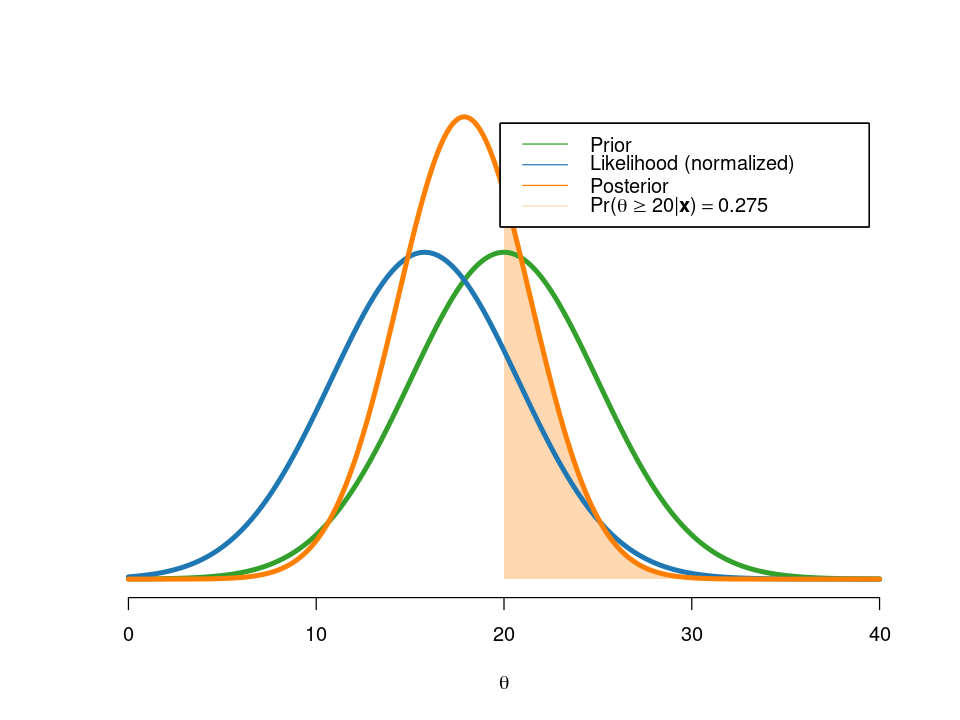

In [166]:
thetaGrid = seq(0, 40, length = 1000) # Some suitable grid of values to plot over
areaPoint = 20 # shade the region where theta>= areaPoint (20 in my example)
n = 1
post = postGaussianIID(x[1:n], mu_0, tau2_0, sigma2, thetaGrid, areaPoint)

We see that the prior and data information happen to get the same weight (w) in the posterior. That is a coincidence from the fact that the prior variance $\tau_0^2$ is the same as the data variance $\sigma^2$.

Moving on, let's add the next measurement to the analysis:

Posterior mean is  18.757 
Posterior standard deviation is  2.887 
The weight on the sample mean is  0.667

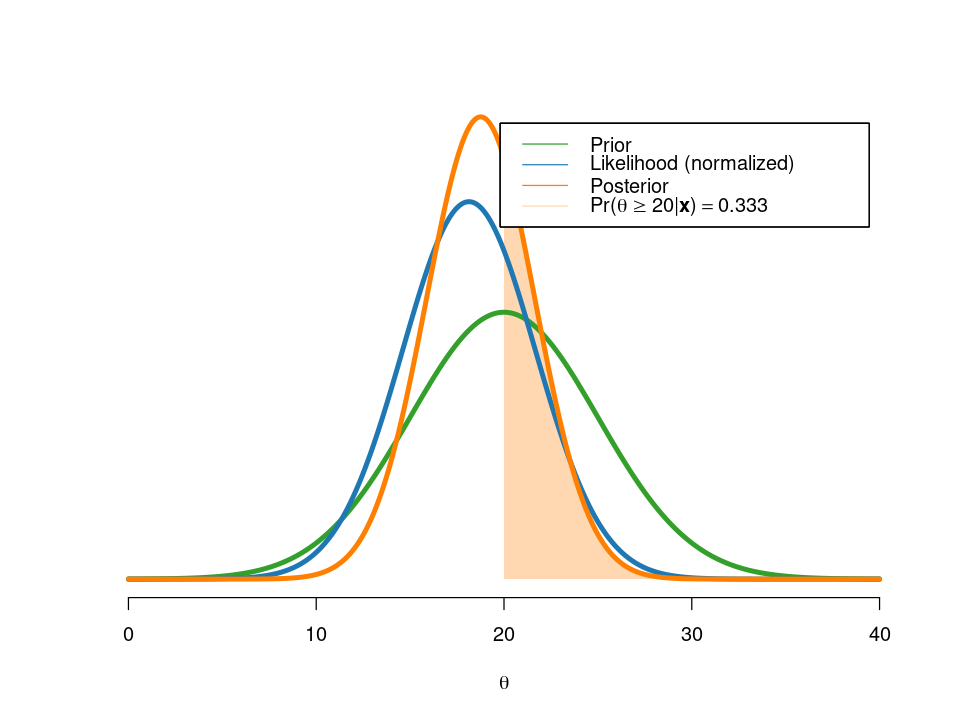

In [167]:
n = 2
post = postGaussianIID(x[1:n], mu_0, tau2_0, sigma2, thetaGrid, areaPoint)

We now see that the posterior is more affected by the data information than the prior information (w = 0.666).

Finally, adding all $n=5$ data points gives:

Posterior mean is  16.665 
Posterior standard deviation is  2.041 
The weight on the sample mean is  0.833

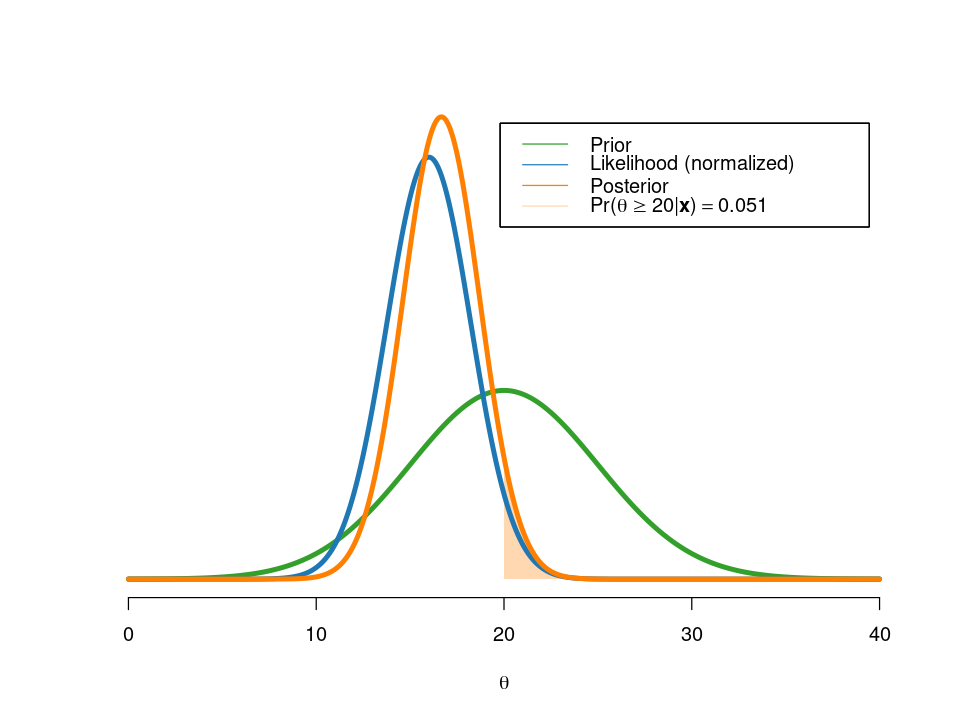

In [168]:
n = 5
post = postGaussianIID(x[1:n], mu_0, tau2_0, sigma2, thetaGrid, areaPoint)

I am now rather sure that my average download speed is less than 20 MBit/sec since the posterior probability of $\theta\geq20$ is only $0.051$.